# Simplex Trees from Context Vectors of Transformers

In this notebook, we show how to plot the simplex trees obtained from persistent homology of the context vectors computed by individual attention heads of `xlm-roberta-large`, where context vectors are treated as points in Euclidean space and persistent homology is computed using the distance matrix of pairwise Euclidean distances between the context vectors. We Show how to plot the Hasse diagram version of the simplex tree, as well as the tree obtained by filtering out certain edges. In particular, we only include edges from simplices in the simplex tree that indicate inclusions of simplices into simplices of one dimension higher. We also filter out edges indicating inclusions that occur after the first inclusion of a simplex into a higher dimensional simplex based on the filtration order. Note that currently, the code does not include special tokens in the simplex trees, but by setting each instance of `add_special_tokens=False` to be `add_special_tokens=True` we can plot only the tokens corresponding to words or subwords. 

## Understanding Sentence Parsing via Simplex Trees from Persistent Homology

In order to understand how a model parses a sentence, we can leverage the notion of *persistent homology* - a concept from the field of computational topology that allows us to extract and quantify the topological features of a dataset at different scales. For the case of sentences processed by a transformer-based model such as BERT, we compute the persistent homology of the context vectors of an individual attention head to generate what we call a *simplex tree*. This tree provides a visual and mathematical representation of the hierarchical relationships between words in the sentence as understood by the model.

## Persistent Homology

Persistent homology provides a multiscale analysis of a dataset by studying the evolution of its topological features (connected components, loops, voids, etc.) as a function of a particular parameter. In the case of context vectors, this parameter can be considered as a distance threshold. We start with all points (context vectors corresponding to tokens) isolated, and as we increase this threshold, points within the threshold distance get connected, forming higher-dimensional structures (edges, triangles, tetrahedra, etc.) called simplices.

Mathematically, given a set of vectors $V = \{v_1, v_2, \ldots, v_n\}$, we construct a *filtration* of simplicial complexes $K_1 \subset K_2 \subset \ldots \subset K_m$, where each $K_i$ is a simplicial complex formed by connecting vectors within a distance $d_i$. The simplicial complex $K_i$ is a collection of simplices, where a k-simplex is a set of $k+1$ vectors that are pairwise connected.

In other words, we start with $K_1$ where no vectors are connected (0-simplices), and as we increase the distance threshold, more vectors get connected forming 1-simplices (edges), 2-simplices (triangles), and so on.

## Simplex Trees

A simplex tree is a data structure that efficiently encodes a simplicial complex. Each node in the tree represents a simplex in the complex, and the parent-child relationships in the tree correspond to the face-subface relationships between simplices. The root of the tree is the empty set, and the children of a node are the simplices that can be obtained by adding one vertex to the simplex corresponding to the node.

In the context of our study, each node in the simplex tree corresponds to a set of connected tokens (or a single token), and an edge between two nodes indicates that the set of tokens at the child node can be obtained by adding one token to the set at the parent node. The filtration value of a node in the simplex tree corresponds to the distance threshold at which the corresponding simplex appears in the filtration.

## Interpreting the Simplex Tree

The structure of the simplex tree allows us to understand how the model is parsing the sentence. For example, an edge between nodes corresponding to the tokens "the" and "the cat" suggests that "cat" is added to "the" at a certain point in the parsing process. Moreover, the filtration values provide a measure of the relative importance of different relationships - the smaller the filtration value, the more significant the relationship. This is because simplices that appear earlier in the filtration (i.e., at lower distance thresholds) correspond to stronger connections between the corresponding vectors, and hence tokens.


In [1]:
pip install numpy matplotlib scikit-learn gudhi pot transformers -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!conda install -c alubbock pygraphviz -y

Retrieving notices: ...working... done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.2

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.2



# All requested packages already installed.



In [9]:
import numpy as np
import gudhi as gd
import torch
from gudhi.wasserstein.barycenter import lagrangian_barycenter as bary
from gudhi.persistence_graphical_tools import plot_persistence_diagram
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from scipy.spatial import distance_matrix
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

In [10]:
text_1 = ["DTLKSEKNADFKDLY", 
          
          "DVVSPPVCGN",
          
          "MGWGRKRR",

          "GFGD"]

In [84]:
def compute_output_model(tokenizer, model, sentence, layer, head):

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O


def compute_phrase_distances_and_homology(tokenizer, context_vectors, sentence, phrase):
    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # If the phrase is not found in the sentence, return a default value or raise an error
    if not phrase_indices:
        raise ValueError("Phrase not found in sentence")

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[phrase_indices]  # <-- Changed this line

    # Print diagnostics
    #print(f"context_vectors.shape: {context_vectors.shape}")
    #print(f"phrase_indices: {phrase_indices}")
    #print(f"phrase_context_vectors.shape: {phrase_context_vectors.shape}")

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=17)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    return persistent_homology, simplex_tree






def print_simplex_tree(persistent_homology, sentence_index, layer_index):
    # Get the homology and simplex tree for the specified sentence, layer, and head
    homology, simplex_tree = persistent_homology[sentence_index][layer_index]

    print(f"Simplex tree for sentence {sentence_index+1}, layer {layer_index+1}:")

    for simplex, filtration_value in simplex_tree.get_filtration():
        print(f"Simplex: {simplex}, Filtration value: {filtration_value}")

    print("\n")



def print_simplex_tree_with_tokens(persistent_homology, tokenizer, sentence, sentence_index, layer_index):
    # Get the homology and simplex tree for the specified sentence, layer, and head
    homology, simplex_tree = persistent_homology[sentence_index][layer_index]

    # Tokenize the sentence
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)

    print(f"Simplex tree for sentence {sentence_index+1}, layer {layer_index+1}:")

    for simplex, filtration_value in simplex_tree.get_filtration():
        # Convert the indices of the simplex into tokens
        simplex_tokens = [sentence_tokens[i] for i in simplex]

        # Convert the tokens back into words
        words = tokenizer.decode(simplex_tokens)

        print(f"Simplex: {simplex}, Words: {words}, Filtration value: {filtration_value}")

    print("\n")



def plot_simplex_tree(simplex_tree):
    '''Plots the Hasse diagram of the simplex tree'''

    # Create a directed graph
    graph = nx.DiGraph()

    # Create a node for each simplex in the simplex tree
    for simplex_tuple in simplex_tree.get_skeleton(1):
        simplex, filtration_value = simplex_tuple
        # Convert the simplex (which is a list of vertices) into a string so that it can be used as a node label
        simplex_str = ', '.join(str(vertex) for vertex in simplex)
        graph.add_node(simplex_str)

    # Add an edge for each pair of simplices where one is a face of the other
    for simplex_tuple in simplex_tree.get_skeleton(2):
        simplex, filtration_value = simplex_tuple
        simplex_str = ', '.join(str(vertex) for vertex in simplex)
        for sub_simplex in itertools.combinations(simplex, len(simplex)-1):
            sub_simplex_str = ', '.join(str(vertex) for vertex in sub_simplex)
            graph.add_edge(sub_simplex_str, simplex_str)

    # Draw the graph
    nx.draw(graph, with_labels=True)
    plt.show()



def plot_simplex_tree_with_tokens(simplex_tree, tokens):
    '''Plots the Hasse diagram of the simplex tree with tokens as node labels'''

    # Create a directed graph
    graph = nx.DiGraph()

    # Create a node for each simplex in the simplex tree
    for simplex_tuple in simplex_tree.get_skeleton(1):
        simplex, filtration_value = simplex_tuple
        # Convert the simplex (which is a list of vertices) into a string of tokens so that it can be used as a node label
        simplex_str = ', '.join(tokens[vertex] for vertex in simplex)
        graph.add_node(simplex_str)

    # Add an edge for each pair of simplices where one is a face of the other
    for simplex_tuple in simplex_tree.get_skeleton(2):
        simplex, filtration_value = simplex_tuple
        simplex_str = ', '.join(tokens[vertex] for vertex in simplex)
        for sub_simplex in itertools.combinations(simplex, len(simplex)-1):
            sub_simplex_str = ', '.join(tokens[vertex] for vertex in sub_simplex)
            graph.add_edge(sub_simplex_str, simplex_str)

    # Draw the graph
    nx.draw(graph, node_color='skyblue', with_labels=True)
    plt.show()




In [78]:
# Define your protein sequences
text_1 = ["DTLKSEKNADFKDLY", "DVVSPPVCGN", "MGWGRKRR", "GFGD"]

def get_hidden_states(tokenizer, model, input_sequence, layer):
    model.config.output_hidden_states = True
    encoded_input = tokenizer([input_sequence], return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        model_output = model(**encoded_input)
    hidden_states = model_output.hidden_states
    specific_hidden_states = hidden_states[layer][0]
    return specific_hidden_states

context = []
for i in range(len(text_1)):
    sentence_context = []
    for layer in range(num_layers):
        sentence_context.append(get_hidden_states(tokenizer, model, text_1[i], layer))
    context.append(sentence_context)



In [79]:
paragraph = 0
layer = model.config.num_hidden_layers -1
# head = 3

print(context[paragraph][layer].shape)
print(context[paragraph][layer])

torch.Size([17, 320])
tensor([[ 1.3687,  3.9937,  1.5944,  ...,  1.0458,  1.7127, -3.4768],
        [-0.9602, -0.4789,  1.3054,  ..., -0.0551, -0.2902,  0.4337],
        [-1.4410,  1.5349, -0.3159,  ...,  1.2702,  0.4827,  0.8998],
        ...,
        [-0.1745, -0.4166,  1.4863,  ...,  2.1153, -0.1883,  1.5057],
        [-0.9804, -0.8420,  1.8399,  ...,  2.7990, -0.5300,  0.1437],
        [-0.6264, -0.0681,  0.3907,  ..., -0.2634, -3.2930, -1.8761]])


In [80]:
paragraph = 3
layer = model.config.num_hidden_layers -1
# head = 1

print(context[paragraph][layer].shape)
print(context[paragraph][layer])

torch.Size([6, 320])
tensor([[ 1.1197,  3.4371,  1.3596,  ...,  1.4375,  2.5049, -2.2390],
        [ 0.1515, -1.4587, -0.8632,  ...,  1.6222,  1.3500,  0.1331],
        [-0.4187, -0.2884,  1.7666,  ...,  1.2738, -0.5460,  1.6786],
        [-0.8811, -0.4473,  0.8480,  ...,  0.0474,  0.5213,  0.6413],
        [-0.7298, -1.6686,  2.6015,  ...,  0.0926,  0.3362,  1.1525],
        [-0.2910, -0.8333,  1.2801,  ..., -0.2936, -2.3776,  0.2945]])


In [81]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")

# Get the number of layers in the model
num_layers = model.config.num_hidden_layers

persistent_homology = []

for i in range(len(text_1)):
    sentence_persistent_homology = []
    for layer in range(num_layers):
        # Calculate persistent homology for each layer
        sentence_persistent_homology.append(compute_phrase_distances_and_homology(tokenizer, context[i][layer], text_1[i], text_1[i]))
    persistent_homology.append(sentence_persistent_homology)



In [85]:
print_simplex_tree_with_tokens(persistent_homology, tokenizer, text_1[3], sentence_index=3, layer_index=3)


Simplex tree for sentence 4, layer 4:
Simplex: [0], Words: G, Filtration value: 0.0
Simplex: [1], Words: F, Filtration value: 0.0
Simplex: [2], Words: G, Filtration value: 0.0
Simplex: [3], Words: D, Filtration value: 0.0
Simplex: [1, 3], Words: F D, Filtration value: 8.367537202575939
Simplex: [1, 2], Words: F G, Filtration value: 10.211357383033425
Simplex: [2, 3], Words: G D, Filtration value: 10.713435078641204
Simplex: [1, 2, 3], Words: F G D, Filtration value: 10.713435078641204
Simplex: [0, 1], Words: G F, Filtration value: 17.42489116223308
Simplex: [0, 3], Words: G D, Filtration value: 19.03034356074352
Simplex: [0, 1, 3], Words: G F D, Filtration value: 19.03034356074352
Simplex: [0, 2], Words: G G, Filtration value: 19.775500929665736
Simplex: [0, 1, 2], Words: G F G, Filtration value: 19.775500929665736
Simplex: [0, 2, 3], Words: G G D, Filtration value: 19.775500929665736
Simplex: [0, 1, 2, 3], Words: G F G D, Filtration value: 19.775500929665736




In [87]:
print_simplex_tree_with_tokens(persistent_homology, tokenizer, text_1[2], sentence_index=2, layer_index=model.config.num_hidden_layers-1)


Simplex tree for sentence 3, layer 6:
Simplex: [0], Words: M, Filtration value: 0.0
Simplex: [1], Words: G, Filtration value: 0.0
Simplex: [2], Words: W, Filtration value: 0.0
Simplex: [3], Words: G, Filtration value: 0.0
Simplex: [4], Words: R, Filtration value: 0.0
Simplex: [5], Words: K, Filtration value: 0.0
Simplex: [6], Words: R, Filtration value: 0.0
Simplex: [7], Words: R, Filtration value: 0.0
Simplex: [2, 4], Words: W R, Filtration value: 13.543265714546074
Simplex: [5, 7], Words: K R, Filtration value: 14.091072070532448
Simplex: [6, 7], Words: R R, Filtration value: 23.106569634815827
Simplex: [4, 7], Words: R R, Filtration value: 24.629707364865133
Simplex: [2, 7], Words: W R, Filtration value: 25.85627768719395
Simplex: [2, 4, 7], Words: W R R, Filtration value: 25.85627768719395
Simplex: [4, 6], Words: R R, Filtration value: 26.21770120598413
Simplex: [4, 6, 7], Words: R R R, Filtration value: 26.21770120598413
Simplex: [1, 7], Words: G R, Filtration value: 26.3497216815

In [88]:
# Tokenize the sentence
sentence_index = 0
sentence_tokens = tokenizer.encode(text_1[sentence_index], add_special_tokens=False)

print(f"Sentence {sentence_index+1} tokens:")
for token in sentence_tokens:
    # Convert the token back into a word
    word = tokenizer.decode([token])
    print(f"Token: {token}, Word: {word}")


Sentence 1 tokens:
Token: 13, Word: D
Token: 11, Word: T
Token: 4, Word: L
Token: 15, Word: K
Token: 8, Word: S
Token: 9, Word: E
Token: 15, Word: K
Token: 17, Word: N
Token: 5, Word: A
Token: 13, Word: D
Token: 18, Word: F
Token: 15, Word: K
Token: 13, Word: D
Token: 4, Word: L
Token: 19, Word: Y


In [89]:
print_simplex_tree_with_tokens(persistent_homology, tokenizer, text_1[2], sentence_index=2, layer_index=model.config.num_hidden_layers-1)


Simplex tree for sentence 3, layer 6:
Simplex: [0], Words: M, Filtration value: 0.0
Simplex: [1], Words: G, Filtration value: 0.0
Simplex: [2], Words: W, Filtration value: 0.0
Simplex: [3], Words: G, Filtration value: 0.0
Simplex: [4], Words: R, Filtration value: 0.0
Simplex: [5], Words: K, Filtration value: 0.0
Simplex: [6], Words: R, Filtration value: 0.0
Simplex: [7], Words: R, Filtration value: 0.0
Simplex: [2, 4], Words: W R, Filtration value: 13.543265714546074
Simplex: [5, 7], Words: K R, Filtration value: 14.091072070532448
Simplex: [6, 7], Words: R R, Filtration value: 23.106569634815827
Simplex: [4, 7], Words: R R, Filtration value: 24.629707364865133
Simplex: [2, 7], Words: W R, Filtration value: 25.85627768719395
Simplex: [2, 4, 7], Words: W R R, Filtration value: 25.85627768719395
Simplex: [4, 6], Words: R R, Filtration value: 26.21770120598413
Simplex: [4, 6, 7], Words: R R R, Filtration value: 26.21770120598413
Simplex: [1, 7], Words: G R, Filtration value: 26.3497216815

In [90]:
# Tokenize the sentence
sentence_index = 2
sentence_tokens = tokenizer.encode(text_1[2], add_special_tokens=False)

print(f"Sentence {sentence_index+1} tokens:")
for token in sentence_tokens:
    # Convert the token back into a word
    word = tokenizer.decode([token])
    print(f"Token: {token}, Word: {word}")

Sentence 3 tokens:
Token: 20, Word: M
Token: 6, Word: G
Token: 22, Word: W
Token: 6, Word: G
Token: 10, Word: R
Token: 15, Word: K
Token: 10, Word: R
Token: 10, Word: R


### Plotting Simplex Tree Based on Inclusion

Plotting the simplex tree based solely on inclusion does not give a tree, it only gives a directed acyclic graph (a Hasse diagram). Here, we plot this Hasse diagram. 

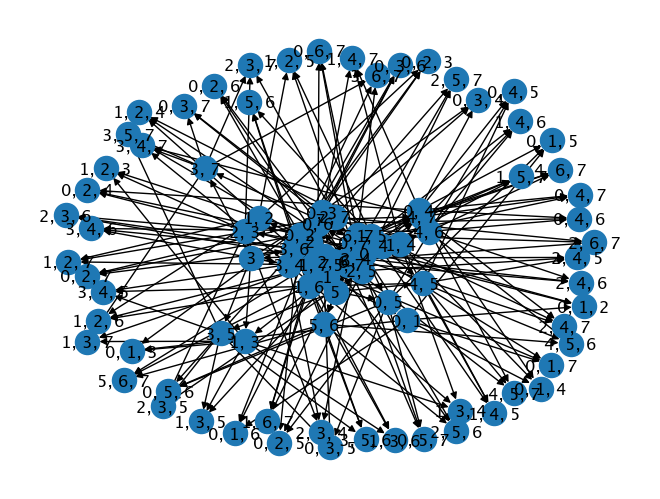

In [92]:
# compute persistent homology and simplex tree
import networkx as nx
layer = 2
# head = 1
hidden_states = context[2][layer]
persistent_homology_0, simplex_tree_0 = compute_phrase_distances_and_homology(tokenizer, hidden_states, text_1[2], text_1[2])

# plot the simplex tree
plot_simplex_tree(simplex_tree_0)



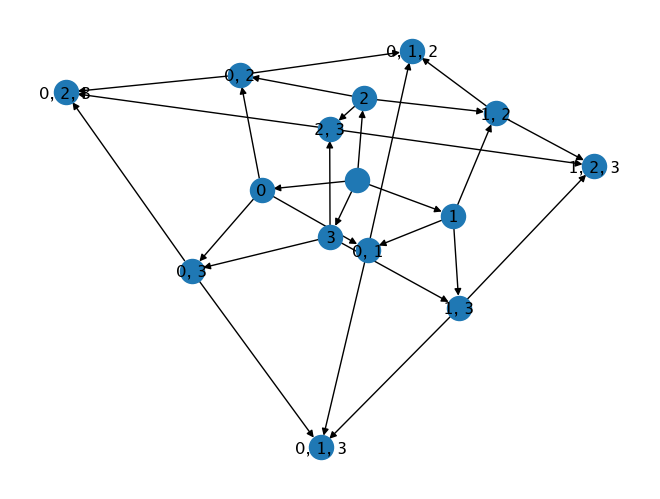

In [97]:
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 5
context_vectors = context[3][layer]
persistent_homology_1, simplex_tree_1 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[3], text_1[3])

# plot the simplex tree
plot_simplex_tree(simplex_tree_1)

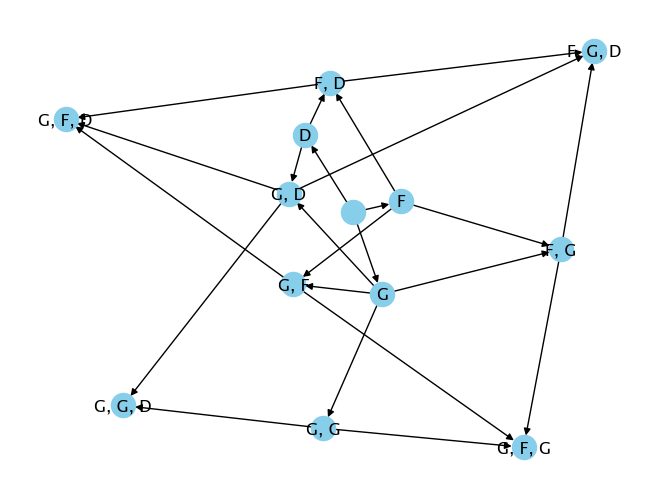

In [114]:
token_ids = tokenizer.encode(text_1[3], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

plot_simplex_tree_with_tokens(simplex_tree_1, tokens)

### Plotting the Simplex Tree as a Tree

Here we filter out the edges that give inclusions that happen at later filtration values than the first, that is, we only include the edges indication inclusions that happen first in the filtration order. We also only draw inclusions from one dimension lower. 

In [128]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from networkx.drawing.nx_pydot import graphviz_layout

def plot_simplex_tree_as_tree(simplex_tree):
    '''Plots the tree diagram of the simplex tree using the filtration order and only including edges 
    between cimplices of consecutive dimension'''    

    G = nx.DiGraph()
    already_included = set()

    for simplex, filtration in simplex_tree.get_filtration():
        simplex = tuple(sorted(simplex))
        G.add_node(simplex)
        if len(simplex) > 1:
            # Only add edges for immediate sub-simplices
            for sub_simplex in combinations(simplex, len(simplex)-1):
                sub_simplex = tuple(sorted(sub_simplex))
                if sub_simplex in G.nodes() and sub_simplex not in already_included:
                    G.add_edge(sub_simplex, simplex)
                    already_included.add(sub_simplex)

    # Create a new figure with desired size
    plt.figure(figsize=(35, 5))  # adjust as needed

    # Use Graphviz for layout
    pos = graphviz_layout(G, prog='dot')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue')

    # edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.show()


/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/3830780495.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


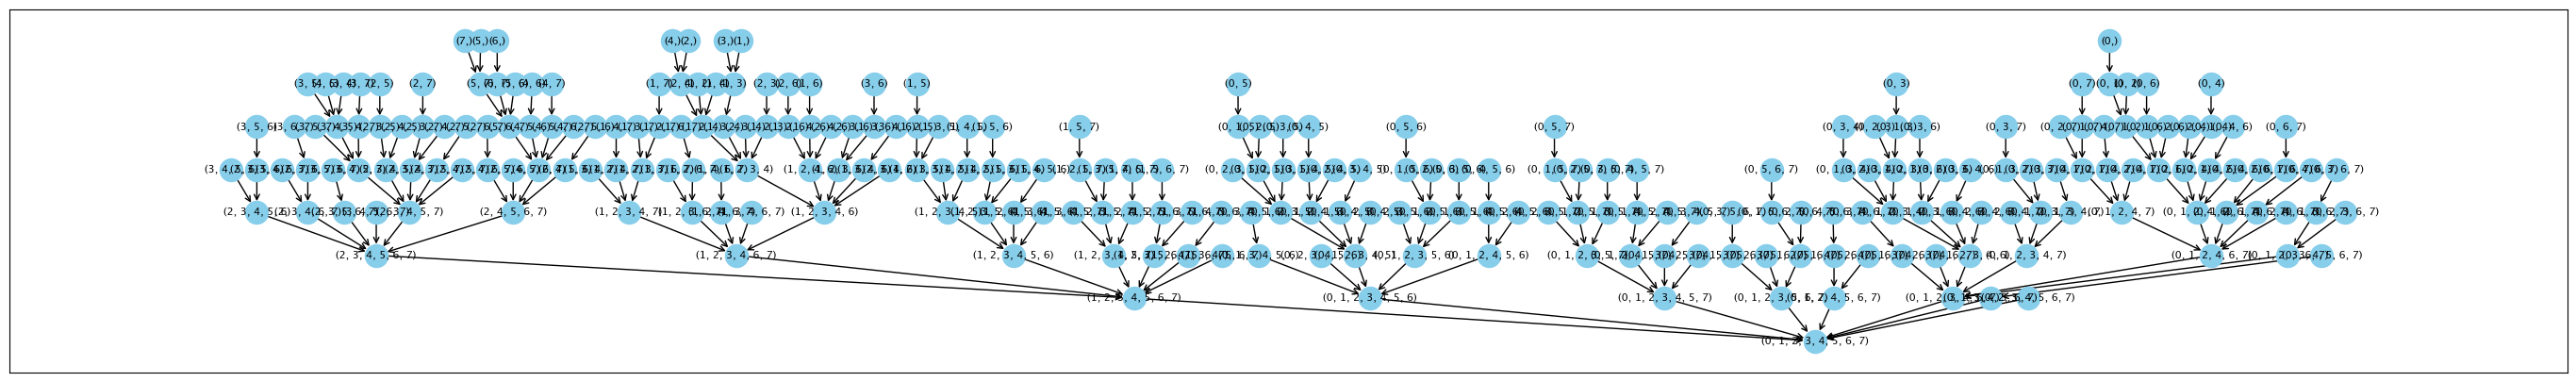

In [120]:
# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree(simplex_tree_0)

Now let's plot the simplex tree for a the third text for `layer = 2` and `head = 1`. 

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/3962461283.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


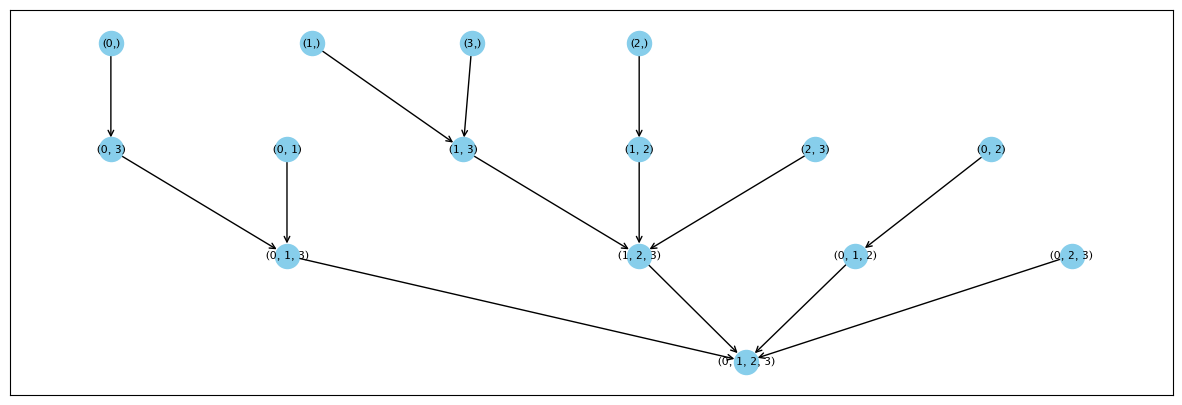

In [123]:
# compute persistent homology and simplex tree
import networkx as nx
layer = 2
head = 1
context_vectors = context[3][layer]
persistent_homology_1, simplex_tree_1 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[3], text_1[3])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree(simplex_tree_1)


Now let's plot the simplex tree for a the third text for the final layer. 

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/3962461283.py:28: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


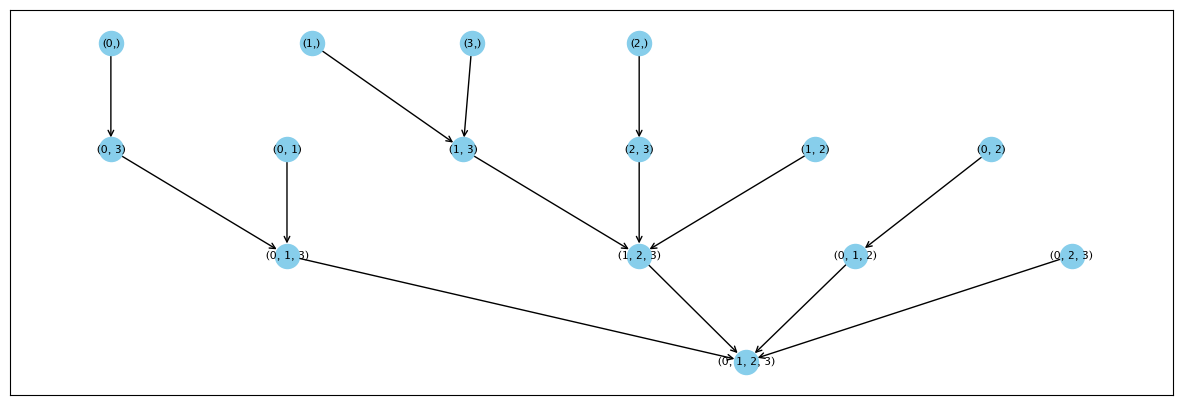

In [125]:
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 5
context_vectors = context[3][layer]
persistent_homology_2, simplex_tree_2 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[3], text_1[3])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree(simplex_tree_2)

### Plotting the Simplex Tree with Tokens as Labels

In [136]:
def plot_simplex_tree_as_tree_with_tokens(simplex_tree, tokens):
    '''Plots the tree diagram of the simplex tree using the filtration order and only including edges 
    between simplices of consecutive dimension. The nodes are labeled with tokens instead of simplices'''    

    G = nx.DiGraph()
    already_included = set()

    for simplex, filtration in simplex_tree.get_filtration():
        simplex = tuple(sorted(simplex))
        G.add_node(simplex)
        if len(simplex) > 1:
            # Only add edges for immediate sub-simplices
            for sub_simplex in combinations(simplex, len(simplex)-1):
                sub_simplex = tuple(sorted(sub_simplex))
                if sub_simplex in G.nodes() and sub_simplex not in already_included:
                    G.add_edge(sub_simplex, simplex)
                    already_included.add(sub_simplex)

    # Create a new figure with desired size
    plt.figure(figsize=(50, 5))  # adjust as needed

    # Use Graphviz for layout
    pos = graphviz_layout(G, prog='dot')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue')

    # edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

    # labels
    labels = {simplex: ' '.join(tokens[i] for i in simplex) for simplex in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.show()


/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/1589575377.py:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


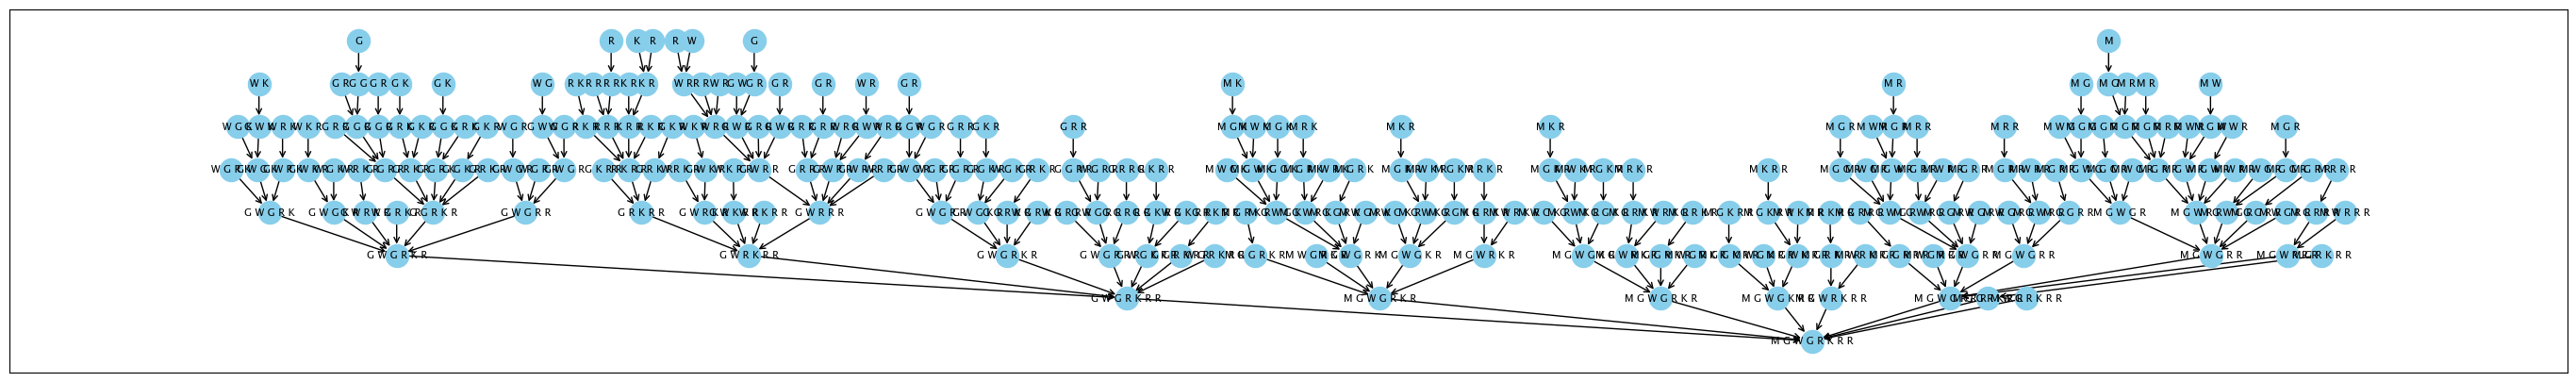

In [130]:
token_ids = tokenizer.encode(text_1[2], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 5
context_vectors = context[2][layer]
persistent_homology_0, simplex_tree_0 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[2], text_1[2])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens(simplex_tree_0, tokens)

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/681037247.py:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


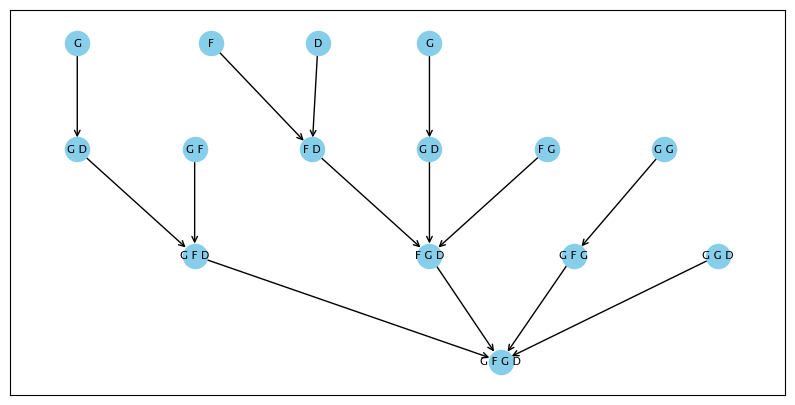

In [132]:
token_ids = tokenizer.encode(text_1[3], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 2
context_vectors = context[3][layer]
persistent_homology_2, simplex_tree_2 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[3], text_1[3])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens(simplex_tree_2, tokens)


### Including Simplices of Higher Dimension

Note that in `compute_phrase_distances_and_homology()` the line 

```
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=5)
```

restricts what dimension simplices we compute, and this which ones we can plot. In the following tree, we see that the tree is not connected, and that the higher dimensional simplices corresponding to more than six tokens are not plotted. 

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/3272704154.py:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


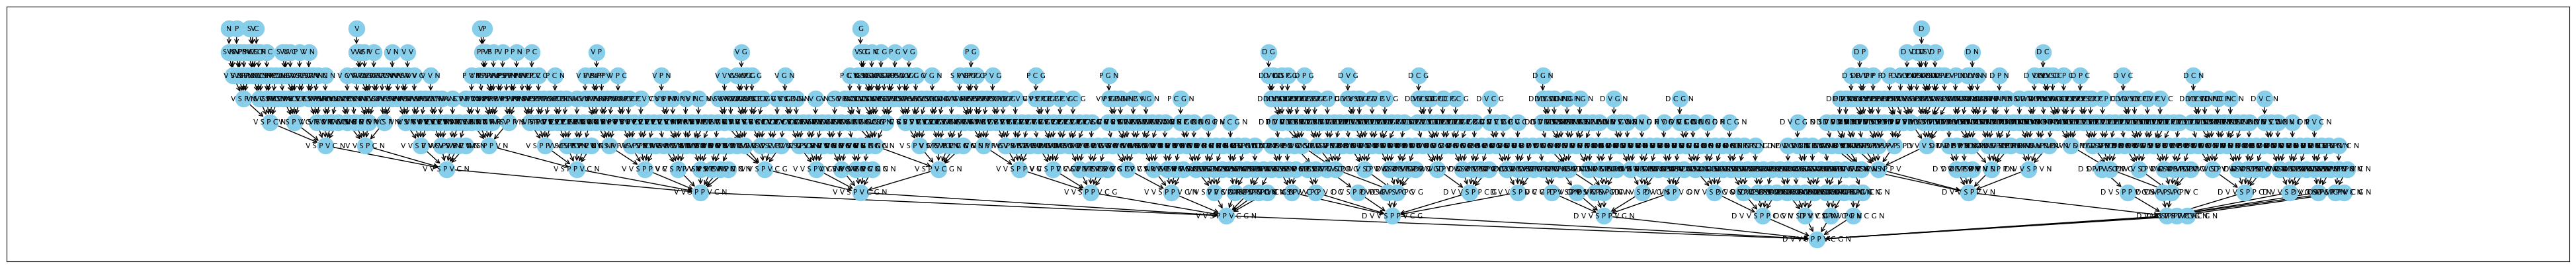

In [137]:
token_ids = tokenizer.encode(text_1[1], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 5
context_vectors = context[1][layer]
persistent_homology_4, simplex_tree_4 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[1], text_1[1])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens(simplex_tree_4, tokens)


In [138]:
# Tokenize the sentence
sentence_index = 1
sentence_tokens = tokenizer.encode(text_1[sentence_index], add_special_tokens=False)

print(f"Sentence {sentence_index+1} tokens:")
for token in sentence_tokens:
    # Convert the token back into a word
    word = tokenizer.decode([token])
    print(f"Token number: {token}, amino acid: {word}")

Sentence 2 tokens:
Token number: 13, amino acid: D
Token number: 7, amino acid: V
Token number: 7, amino acid: V
Token number: 8, amino acid: S
Token number: 14, amino acid: P
Token number: 14, amino acid: P
Token number: 7, amino acid: V
Token number: 23, amino acid: C
Token number: 6, amino acid: G
Token number: 17, amino acid: N


We can change this by simply changing 
```
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=5)
``` 

to 

```
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=7)
``` 

In [143]:
def compute_phrase_distances_and_homology_2(tokenizer, context_vectors, sentence, phrase):

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=7)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    return persistent_homology, simplex_tree

In [151]:
def plot_simplex_tree_as_tree_with_tokens_layout_b(simplex_tree, tokens):
    '''Plots the tree diagram of the simplex tree using the filtration order and only including edges 
    between simplices of consecutive dimension. The nodes are labeled with tokens instead of simplices'''    

    G = nx.DiGraph()
    already_included = set()

    for simplex, filtration in simplex_tree.get_filtration():
        simplex = tuple(sorted(simplex))
        G.add_node(simplex)
        if len(simplex) > 1:
            # Only add edges for immediate sub-simplices
            for sub_simplex in combinations(simplex, len(simplex)-1):
                sub_simplex = tuple(sorted(sub_simplex))
                if sub_simplex in G.nodes() and sub_simplex not in already_included:
                    G.add_edge(sub_simplex, simplex)
                    already_included.add(sub_simplex)

    # Create a new figure with desired size
    plt.figure(figsize=(15, 5))  # adjust as needed

    # Use Graphviz for layout
    pos = graphviz_layout(G, prog='dot')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue')

    # edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

    # labels
    labels = {simplex: '\n'.join(tokens[i] for i in simplex) for simplex in G.nodes()}  # use newline to stack tokens vertically
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.show()


/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/672393555.py:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


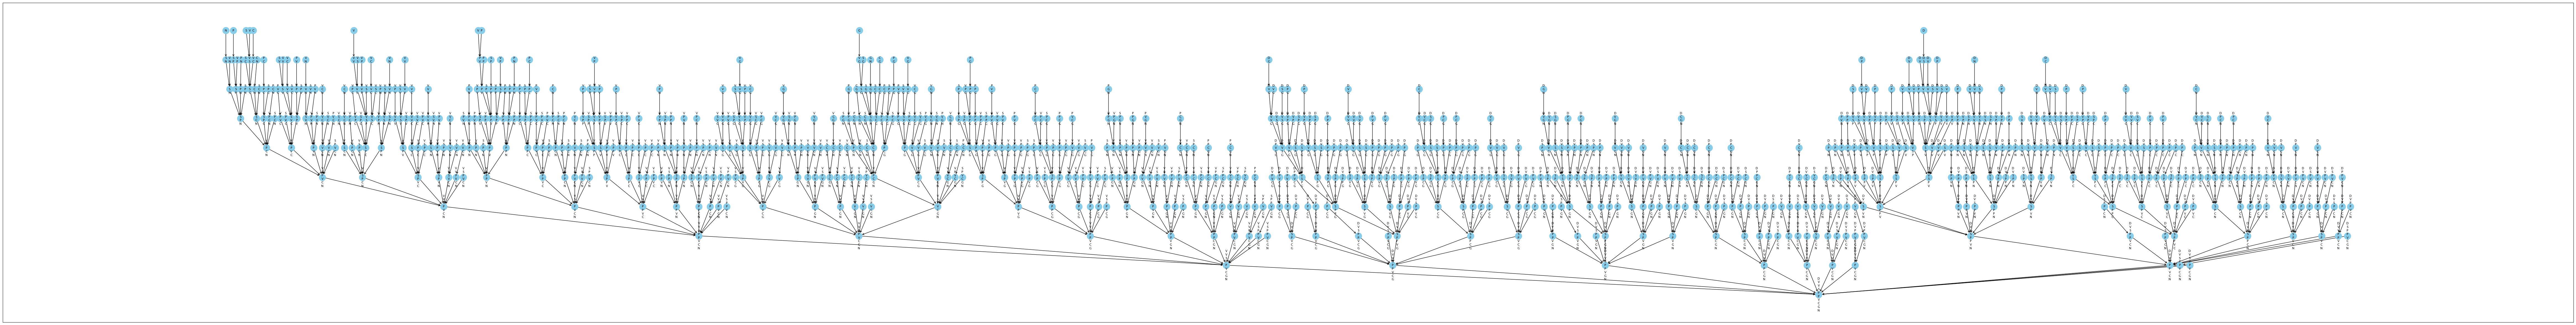

In [145]:
token_ids = tokenizer.encode(text_1[1], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
# head = 5
context_vectors = context[1][layer]
persistent_homology_5, simplex_tree_5 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[1], text_1[1])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens_layout_b(simplex_tree_5, tokens)

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_19884/2891493719.py:23: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


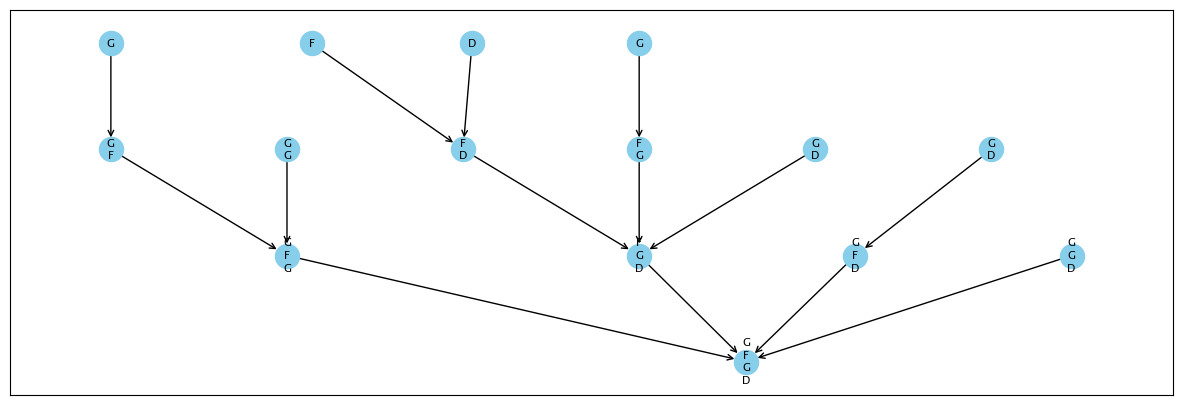

In [152]:
token_ids = tokenizer.encode(text_1[3], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
import networkx as nx
layer = model.config.num_hidden_layers-1
#head = 5
context_vectors = context[2][layer]
persistent_homology_6, simplex_tree_6 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[3], text_1[3])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens_layout_b(simplex_tree_6, tokens)